## 第三次讀書會-第3組
### twitter留言分析

- 課程：社群媒體分析
- 授課教授：黃三益
- 組長：B084020041劉怡謙
- 組員：B094020042黃萱妮、B084020009程尤欣、M114020052王渙鈞、B084020035姚昀誠、B084020031劉杰煊、B065040041蔡瑋駿、M114020055吳均庭

## Outline
- 引入套件
1. About data
    - 分析動機及目的
    - 1.1 資料清理
    - 1.2 資料及基本檢視
2. 分類模型的訓練流程
    - 2.1 根據7:3的比例切分資料集
    - 2.2 將文章轉為 DTM
        - 2.2.1使用CounterVectorizer加上邏輯回歸
        - 2.2.2 改試試看使用 tf-idf 的 DTM 來代表文章，訓練分類模型的效果
        - 2.2.3 cross validation
3. 比較不同模型的效果
4. 分析可解釋模型的結果
    - 4.1 各字詞特徵的estimate係數
5. LDA主題模型
    - 5.1 視覺化結果

#### 引入需要的套件

In [1]:
import re
from pprint import pprint

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold, GridSearchCV
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.matutils import corpus2csc
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk 

import pyLDAvis
import pyLDAvis.gensim

In /opt/miniconda3/envs/TF1/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/miniconda3/envs/TF1/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/miniconda3/envs/TF1/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/miniconda3/envs/TF1/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/miniconda3/envs/TF1/lib/python3.6/site-packa

In [2]:
# 移除警告語，視覺上比較乾淨
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## About data
### 分析動機及目的
網路上的留言資料量龐大，但是如何有效分析這些資料卻是一個挑戰。使用情感分類方法，可以幫助我們將留言分為neutral、positive、negative三個類別，進而更深入地了解網民對於某一特定主題的情感傾向，而我們這裡選擇使用twitter留言作為分析資來源。
這樣的分析可以幫助我們更好地掌握網民對於特定話題的關注度和情感態度，進而對網路上的訊息進行更全面的分析和評估。
#### 引入資料

In [3]:
#import dataset
df = pd.read_csv('./twitter/train.csv')
meta_data = df.copy()
meta_data.head()

,text,sentiment_label
0,@united sat at airport for 5 hrs still sitting...,0
1,😩😩😩 “@JetBlue: Our fleet's on fleek. http://t....,1
2,@SouthwestAir Flight 4110 MCO to ISP delayed. ...,0
3,@USAirways actually it landed in BWI 30 minute...,0
4,@VirginAmerica fav airline,2


### 1.1 清理
利用問號、句號或驚嘆號等符號斷句，最後設定會去除結尾的空白符號。

In [4]:
# 更改label_name
meta_data["sentiment_label"] = meta_data["sentiment_label"].replace({0:'negative',1:'neutral',2:'positive'})

# 移除網址格式
meta_data["text"] = meta_data.text.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 移除標記帳號
meta_data["text"] = meta_data.text.apply(
    lambda x: re.sub(r"@\w+", "", x)
)
# 刪除長度小於1的句子
meta_data = meta_data[~meta_data["text"].str.len() < 1]

# 刪除標點符號/數字/換行符號
meta_data["text"] = meta_data.text.apply(
    lambda x: re.sub(r'[^a-zA-Z\s]', "", x)
)

#stemming
stemmer = PorterStemmer()
for i in range(len(meta_data["text"])):
    words = nltk.word_tokenize(meta_data["text"].iloc[i]) 
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_sentence = " ".join(stemmed_words)
    meta_data.loc[i,"text"] = stemmed_sentence

meta_data.head()

,text,sentiment_label
0,sat at airport for hr still sit at gate sigh,negative
1,our fleet on fleek,neutral
2,flight mco to isp delay ani detail on whi,negative
3,actual it land in bwi minut ago she is strand ...,negative
4,fav airlin,positive


### 1.2 資料集基本檢視

In [5]:
# 看看有幾則留言
print(f"number of posts: {meta_data.shape[0]}")
print(f"category: \n{meta_data['sentiment_label'].value_counts()}")

number of posts: 10248
category: 
negative    6387
neutral     2199
positive    1662
Name: sentiment_label, dtype: int64


## 2. 分類模型的訓練流程
#### 2.1 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 raw_data 隨機切成 7:3，設置 `random_state` 讓每次切分的結果一致。y_train和y_test分別為訓練資料和測試資料的預測目標（每個句子所屬的sentiment label）。

In [6]:
data = meta_data.copy()
X = data["text"]
y = data["sentiment_label"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

X_train.head()

5715    I heart my CP statu sure would be nice to have...
3744    you can do better than have someon on hold for...
598     is the worst worst reserv polici worst costum ...
3540                                     ye parti is over
3108                                whi do you have to be
Name: text, dtype: object

In [7]:
y_train.head()

5715    positive
3744    negative
598     negative
3540     neutral
3108     neutral
Name: sentiment_label, dtype: object

In [8]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['sentiment_label'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
negative    62.324356
neutral     21.457845
positive    16.217799
Name: sentiment_label, dtype: float64

train percentage :
negative    61.592081
neutral     22.138575
positive    16.269343
Name: sentiment_label, dtype: float64

test percentage :
negative    64.032520
neutral     19.869919
positive    16.097561
Name: sentiment_label, dtype: float64


### 2.2 將文章轉為 DTM
#### 2.2.1使用CounterVectorizer加上邏輯回歸

In [9]:
# vectorizer
vectorizer = CountVectorizer(max_features=1000, stop_words="english")
vectorizer.fit(X_train)
vec_train = vectorizer.transform(X_train)
vec_test = vectorizer.transform(X_test)

# classifier
clf = LogisticRegression()
clf.fit(vec_train, y_train)

train_pred = clf.predict(vec_train)
train_pred_proba = clf.predict_proba(vec_train)

y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [10]:
## Accuracy, Precision, Recall, F1-score
print("training set\n",classification_report(y_train, train_pred))

training set
               precision    recall  f1-score   support

    negative       0.88      0.92      0.90      4418
     neutral       0.75      0.71      0.73      1588
    positive       0.83      0.75      0.79      1167

    accuracy                           0.85      7173
   macro avg       0.82      0.79      0.81      7173
weighted avg       0.85      0.85      0.85      7173



In [11]:
## Accuracy, Precision, Recall, F1-score
print("testing set\n",classification_report(y_test, y_pred))

testing set
               precision    recall  f1-score   support

    negative       0.85      0.86      0.86      1969
     neutral       0.56      0.58      0.57       611
    positive       0.71      0.65      0.68       495

    accuracy                           0.77      3075
   macro avg       0.71      0.70      0.70      3075
weighted avg       0.77      0.77      0.77      3075



- 可以看出的negative資料不管是在training set還是testing set都訓練得不錯，但positive跟neutral的結果在testing set表現就表現得沒那麼好

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'negative'), Text(0, 1.5, 'neutral'), Text(0, 2.5, 'positive')])

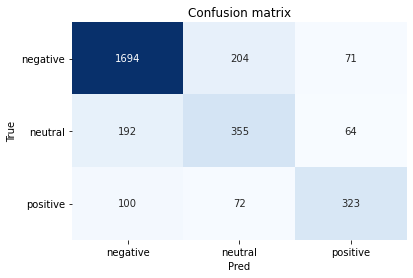

In [12]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

In [13]:
enc = OneHotEncoder(sparse=False)
enc.fit(y_train.values.reshape(-1, 1))
y_onehot_test = enc.transform(y_test.values.reshape(-1, 1))

In [14]:
enc.categories_

[array(['negative', 'neutral', 'positive'], dtype=object)]

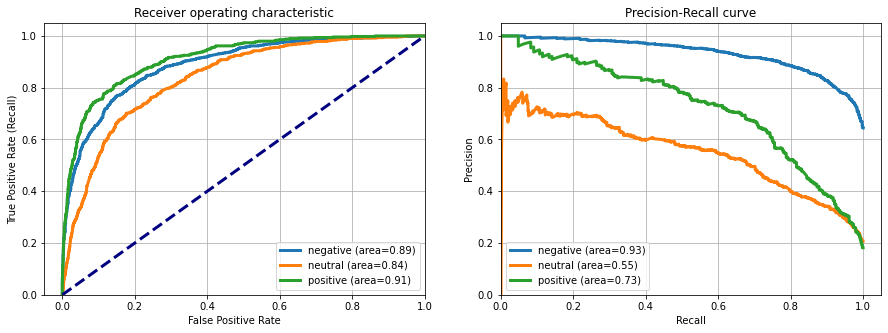

In [15]:
# plot ROC curve and precision-recall curve
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
    ax[0].plot(
        fpr, tpr, lw=3, label="{0} (area={1:0.2f})".format(classes[i], auc(fpr, tpr))
    )
    
ax[0].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
ax[0].set(
    xlim=[-0.05, 1.0],
    ylim=[0.0, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate (Recall)",
    title="Receiver operating characteristic",
)
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(
        y_onehot_test[:, i], y_pred_proba[:, i]
    )
    ax[1].plot(
        recall,
        precision,
        lw=3,
        label="{0} (area={1:0.2f})".format(classes[i], auc(recall, precision)),
    )
ax[1].set(
    xlim=[0.0, 1.05],
    ylim=[0.0, 1.05],
    xlabel="Recall",
    ylabel="Precision",
    title="Precision-Recall curve",
)
ax[1].legend(loc="best")
ax[1].grid(True)

plt.show()

- AUC跟PRAUC 都是越高越好，跟上述結論差不多，都是negative的結果比較好，尤其是neutral的表現不好，推測是資料筆數不多導致訓練不好的關係。

#### 2.2.2 改試試看使用 tf-idf 的 DTM 來代表文章，訓練分類模型的效果

In [16]:
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)

clf.fit(vec_train, y_train)

train_pred = clf.predict(vec_train)
train_pred_proba = clf.predict_proba(vec_train)

y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print("traing set\n",classification_report(y_train, train_pred))
print("testing set\n",classification_report(y_test, y_pred))

traing set
               precision    recall  f1-score   support

    negative       0.84      0.95      0.89      4418
     neutral       0.75      0.61      0.67      1588
    positive       0.84      0.65      0.73      1167

    accuracy                           0.82      7173
   macro avg       0.81      0.73      0.76      7173
weighted avg       0.82      0.82      0.81      7173

testing set
               precision    recall  f1-score   support

    negative       0.81      0.92      0.86      1969
     neutral       0.59      0.48      0.53       611
    positive       0.80      0.57      0.66       495

    accuracy                           0.77      3075
   macro avg       0.73      0.65      0.68      3075
weighted avg       0.76      0.77      0.76      3075



- 表現結果跟logistic差不多，一樣都是neutral, positive留言預測的比較好
- 因為有計算詞頻，可能解釋上比較好理解

#### 2.2.3 cross validation

/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mod

              precision    recall  f1-score   support

    negative       0.82      0.87      0.84      4418
     neutral       0.59      0.56      0.57      1588
    positive       0.70      0.62      0.65      1167

    accuracy                           0.76      7173
   macro avg       0.70      0.68      0.69      7173
weighted avg       0.75      0.76      0.75      7173



/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mod

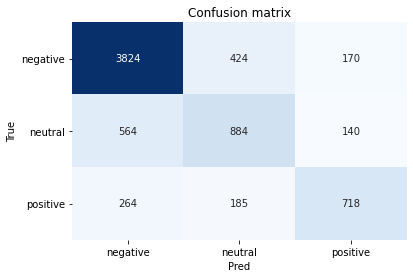

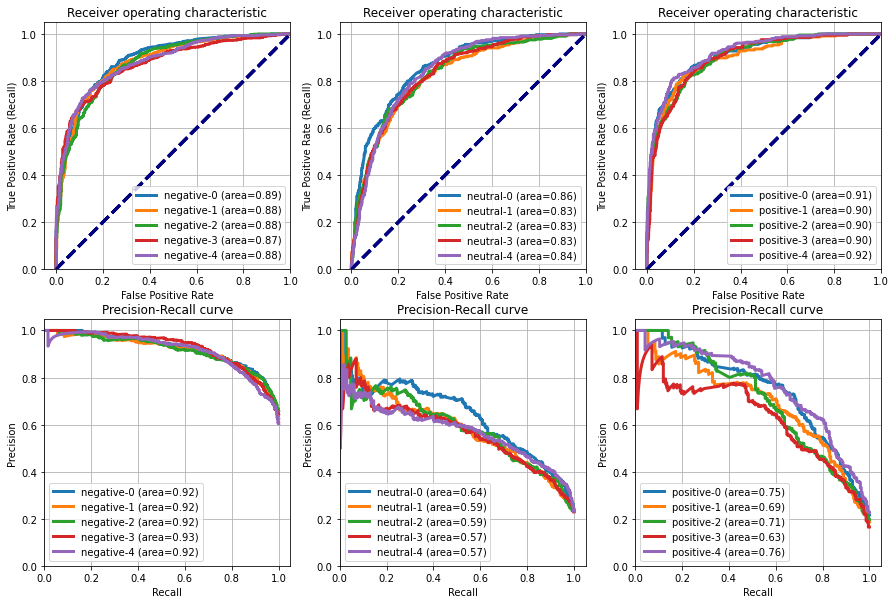

/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [17]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")

    # one-hot encoding
    enc = OneHotEncoder(sparse=False)
    enc.fit(y.values.reshape(-1, 1))
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title="Confusion matrix",
    )
    plt.yticks(rotation=0)


    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

    kf = KFold(n_splits=5)
    
    for k, (train, test) in enumerate(kf.split(vec_X, y)):
        clf.fit(vec_X[train,:], y.iloc[train])
        y_pred = clf.predict(vec_X[test,:])    
        y_test = y.iloc[test]
        y_pred_proba = clf.predict_proba(vec_X[test,:])
        y_onehot_test = enc.transform(y_test.values.reshape(-1, 1))
            
        ## Plot roc
        for i in range(len(classes)):
            fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
            ax[0,i].plot(
                fpr,
                tpr,
                lw=3,
                label="{0}-{1} (area={2:0.2f})".format(classes[i], k, auc(fpr, tpr)),
            )
            ax[0,i].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
            ax[0,i].set(
                xlim=[-0.05, 1.0],
                ylim=[0.0, 1.05],
                xlabel="False Positive Rate",
                ylabel="True Positive Rate (Recall)",
                title="Receiver operating characteristic",
            )
            ax[0,i].legend(loc="best")
            ax[0,i].grid(True)

        ## Plot precision-recall curve
        for i in range(len(classes)):
            precision, recall, thresholds = precision_recall_curve(
                y_onehot_test[:, i], y_pred_proba[:, i]
            )
            ax[1,i].plot(
                recall,
                precision,
                lw=3,
                label="{0}-{1} (area={2:0.2f})".format(classes[i], k,auc(recall, precision)),
            )
            ax[1,i].set(
                xlim=[0.0, 1.05],
                ylim=[0.0, 1.05],
                xlabel="Recall",
                ylabel="Precision",
                title="Precision-Recall curve",
            )
            ax[1,i].legend(loc="best")
            ax[1,i].grid(True)

    plt.show()

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

vectorizer = CountVectorizer(max_features=1000, stop_words="english")
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

- 可以很明顯地看出，利用cross validation之後，整體模型表現好很多，缺點就是運算時間會久一點

## 3. 比較不同模型的效果

now training: clf_logistic
              precision    recall  f1-score   support

    negative       0.80      0.93      0.86      4418
     neutral       0.67      0.52      0.59      1588
    positive       0.79      0.56      0.66      1167

    accuracy                           0.78      7173
   macro avg       0.76      0.67      0.70      7173
weighted avg       0.77      0.78      0.77      7173



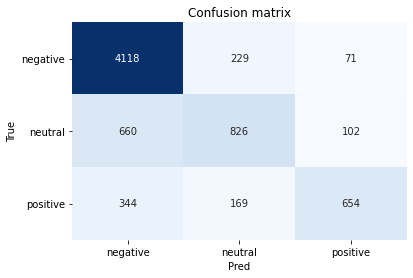

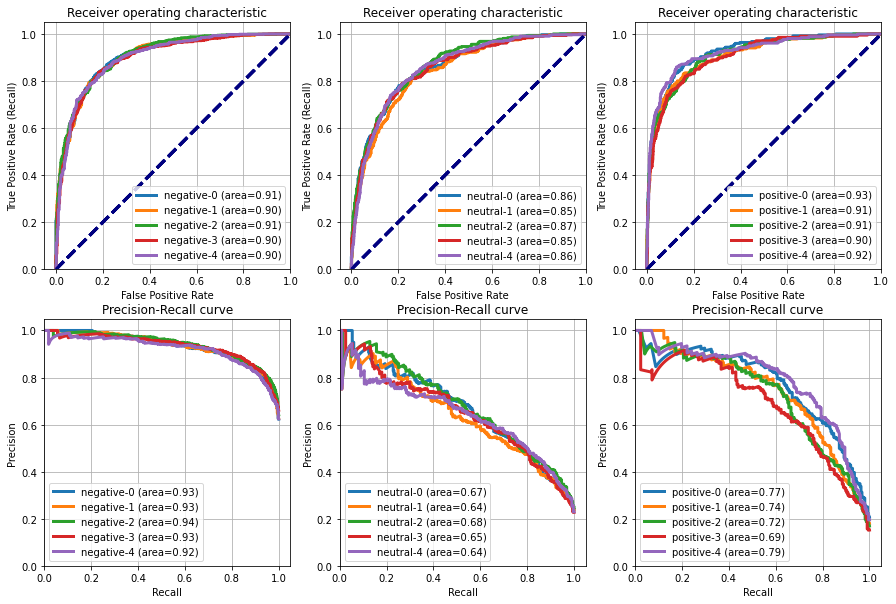

now training: clf_dtree
              precision    recall  f1-score   support

    negative       0.77      0.78      0.78      4418
     neutral       0.44      0.47      0.45      1588
    positive       0.54      0.49      0.51      1167

    accuracy                           0.66      7173
   macro avg       0.58      0.58      0.58      7173
weighted avg       0.66      0.66      0.66      7173



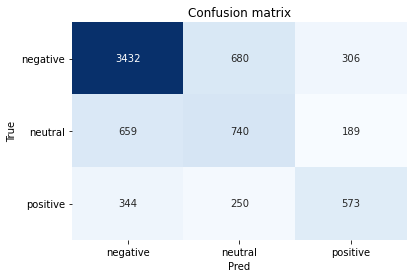

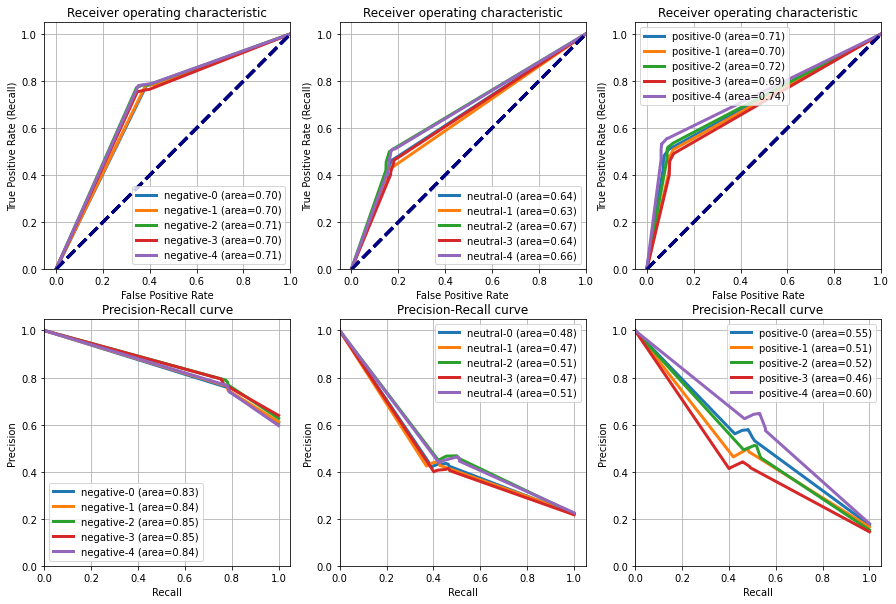

now training: clf_rf
              precision    recall  f1-score   support

    negative       0.76      0.94      0.84      4418
     neutral       0.67      0.40      0.50      1588
    positive       0.77      0.48      0.59      1167

    accuracy                           0.75      7173
   macro avg       0.73      0.61      0.64      7173
weighted avg       0.74      0.75      0.72      7173



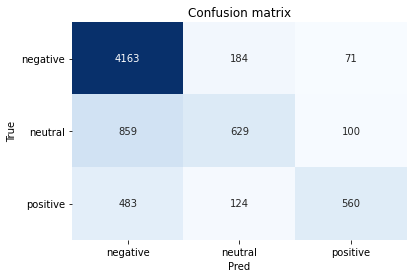

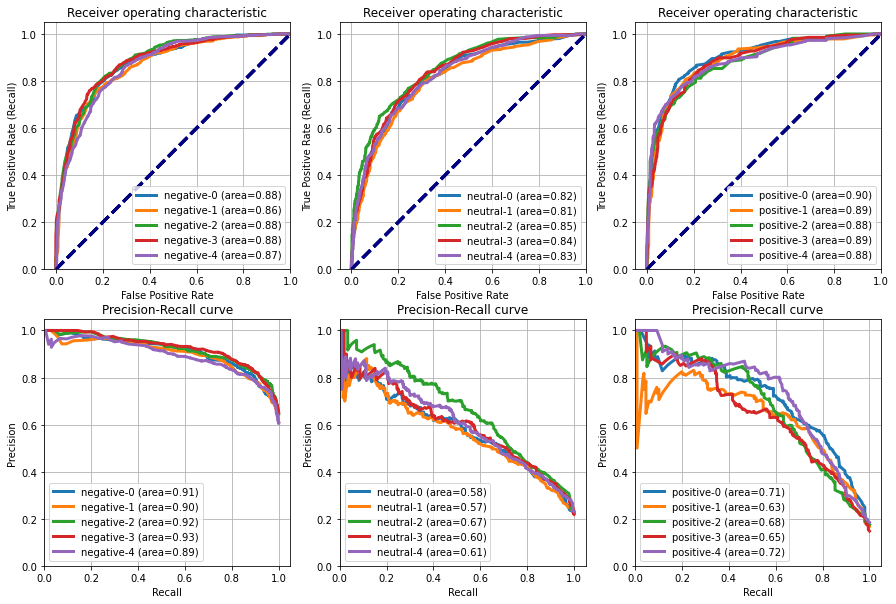

In [18]:
# 準備訓練資料
X = data["text"]
y = data["sentiment_label"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)

In [19]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['macro avg'][best_model_metric] > max:
        max = v['macro avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")

best model: clf_logistic


In [20]:
train_pred = model_set['clf_logistic'].predict(vectorizer.transform(X_train))
y_pred = model_set['clf_logistic'].predict(vectorizer.transform(X_test))
print(classification_report(y_train, train_pred))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.85      0.95      0.90      4418
     neutral       0.79      0.64      0.71      1588
    positive       0.86      0.67      0.75      1167

    accuracy                           0.84      7173
   macro avg       0.83      0.75      0.79      7173
weighted avg       0.84      0.84      0.83      7173

              precision    recall  f1-score   support

    negative       0.84      0.92      0.88      1969
     neutral       0.64      0.55      0.59       611
    positive       0.78      0.60      0.68       495

    accuracy                           0.80      3075
   macro avg       0.75      0.69      0.72      3075
weighted avg       0.79      0.80      0.79      3075



- logistic model 的整體表現最佳，其為training/testing各自的classification report

## 4. 分析可解釋模型的結果
### 4.1 各字詞特徵的estimate係數
+ 這裡舉logistic regression + cv tokenizer 為例

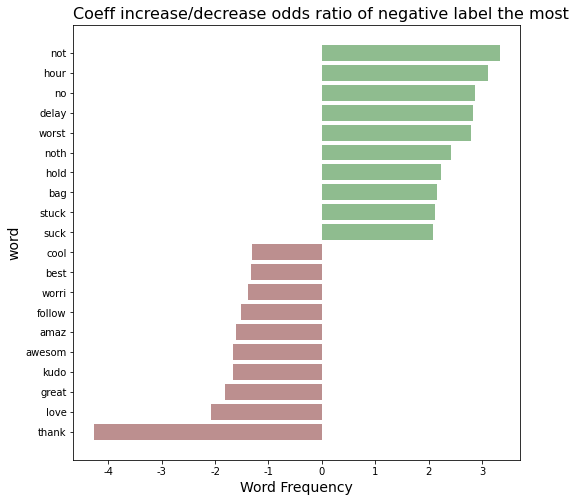

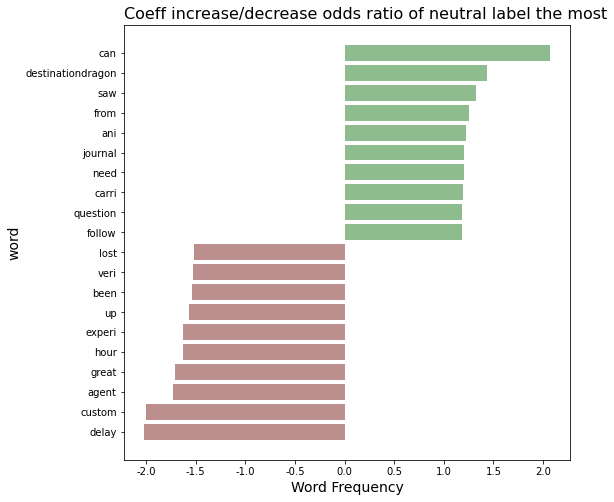

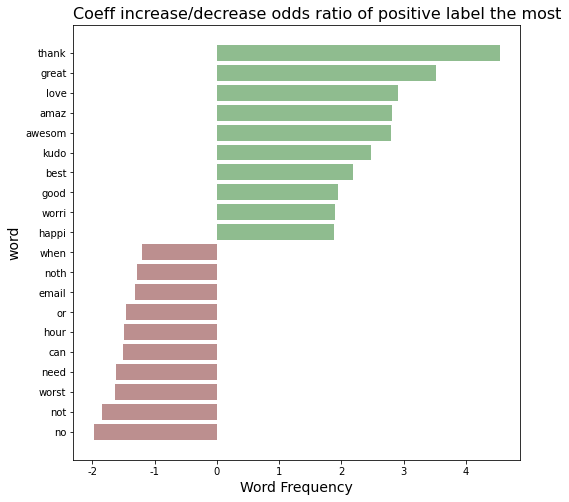

In [21]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of " + label + " label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("Word Frequency", size=14)

# plot logistic model
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names(), top_n=10)

- negative都是負面詞，如：suck, worst, late等
- positive的字詞大多都是稱讚詞，如：thank, love, awesome等
- neutral的字詞為分辨不出情緒的詞彙

## 5. LDA主題模型

In [22]:
#查看清理後的原始資料
data_LDA = meta_data.copy()
data_LDA.head()

,text,sentiment_label
0,sat at airport for hr still sit at gate sigh,negative
1,our fleet on fleek,neutral
2,flight mco to isp delay ani detail on whi,negative
3,actual it land in bwi minut ago she is strand ...,negative
4,fav airlin,positive


In [23]:
stop_words = stopwords.words('english')

In [24]:
data_LDA = data_LDA.groupby('sentiment_label')['text'].apply(lambda x: " ".join(x)).reset_index()
data_LDA.head()

,sentiment_label,text
0,negative,sat at airport for hr still sit at gate sigh f...
1,neutral,our fleet on fleek what are your rule on check...
2,positive,fav airlin thx make it right help meagan fouti...


In [25]:
#過濾停用字
data_LDA['text'] = data_LDA['text'].str.lower()
docs = [[word for word in doc.split() if word not in stop_words] for doc in data_LDA['text']]
len(docs)

3

#### 在 docs 裡面新增出現次數大於 20 次的 bigram

In [26]:
# Compute bigrams.

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [27]:
dictionary = Dictionary(docs)
print(dictionary)

Dictionary<7995 unique tokens: ['aa', 'aaaand', 'aaadvantag', 'aacom', 'aadvantag']...>


In [28]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [29]:
t0 = time.time()

topic_num_list = np.arange(2, 16)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

花費時間: 42.331159353256226 sec


In [30]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,1286.046276,-0.009688
1,3,1353.732810,-0.008767
2,4,1409.878134,-0.006437
3,5,1347.622121,-0.024105
4,6,1396.586267,-0.021750
5,7,1322.033611,-0.027268
6,8,1356.580609,-0.025294
7,9,1394.662374,-0.023958
8,10,1415.820607,-0.022649
9,11,1434.209452,-0.027542


<AxesSubplot:xlabel='topic_num'>

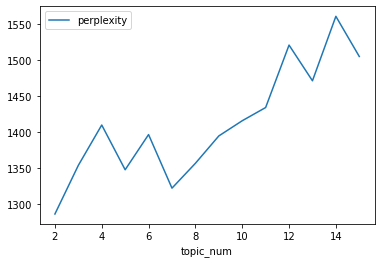

In [31]:
result.plot.line(x='topic_num', y='perplexity')

<AxesSubplot:xlabel='topic_num'>

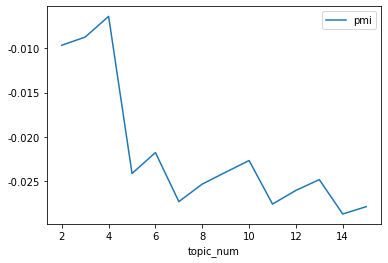

In [32]:
result.plot.line(x='topic_num', y='pmi')

### 5.1 視覺化結果
- 雖然上圖2, 4 perplexity都很低，但以pmi在2比較高，所以參數設**num_topics = 2**

In [33]:
model = LdaModel(
    corpus = corpus,
    num_topics = 2,
    id2word=dictionary,
    random_state = 1500,
    passes=5
    )

In [34]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x    y  topics  cluster      Freq
topic                                          
1      0.031609  0.0       1        1  70.46511
0     -0.031609  0.0       2        1  29.53489, topic_info=        Term         Freq        Total Category  logprob  loglift
5224   thank  1082.000000  1082.000000  Default  30.0000  30.0000
1937  flight  3104.000000  3104.000000  Default  29.0000  29.0000
2252   great   203.000000   203.000000  Default  28.0000  28.0000
3111    love   172.000000   172.000000  Default  27.0000  27.0000
1933     fli   443.000000   443.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
2208      go   103.860275   406.621738   Topic2  -5.6160  -0.1452
121   airlin    96.061091   343.481472   Topic2  -5.6941  -0.0546
387     back    95.304873   344.529173   Topic2  -5.7020  -0.0655
737   cancel   108.703151   700.498324   Topic2  -5.5705  -0.6436
1309   delay    94.403433   622.823954   Topic2  -5.7115  -0.6671

[194 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
121       1  0.719107        airlin
121       2  0.279491        airlin
161       1  0.905380          alon
161       2  0.075448          alon
178       1  0.179167          amaz
...     ...       ...           ...
5936      2  0.069876         worst
5937      1  0.937495  worst_airlin
5937      2  0.058593  worst_airlin
5952      1  0.708795         would
5952      2  0.293196         would

[298 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [35]:
pyLDAvis.save_html(p, "lda_project3.html")

### summary
1. 在找資料集時就可發現出twitter跟ptt一樣都是負面詞會比較多，所以在訓練上也比較容易訓練到
2. logistic直接訓練時就有很好的表現，而決策數可切分的節點數不多，建議還是使用隨機森林比較佳。